In [1]:
from time import time
import itertools

# data analysis and wrangling
import numpy as np
import pandas 

# visualization
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn import metrics

# Acquire data


In [2]:
DataSet='C:/Users/Sushant/Desktop/ML/Projects/NIki_Hiring/LabelledData.txt'

DataSet_df = pandas.read_table(DataSet,sep='\s*[,]{3}\s*',engine='python',header=None,names=['Question','Category'])
target_names = DataSet_df['Category'].unique()
DataSet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 2 columns):
Question    1483 non-null object
Category    1483 non-null object
dtypes: object(2)
memory usage: 23.2+ KB


There are 1483 entries in the Dataset. So lets Split them into Training and Testing examples 

In [3]:
#Shuffle the dataSet 
DataSet_df = DataSet_df.sample(frac= 1).reset_index(drop=True)
#Split DataSet, make a 80-20 Split
train_data, test_data = train_test_split(DataSet_df, test_size = 0.20, random_state = 1)
y_train, y_test = train_data['Category'].values, test_data['Category'].values

# Feature Extraction
Make use of a Bag of Words Approach

In [5]:
#Feature Extraction

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=False, max_df=0.4, min_df=1, stop_words='english')
X_train = vectorizer.fit_transform(train_data['Question'].values)
duration = time() - t0
print("done in %fs" % duration)
print("num_samples: %d, num_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(test_data['Question'].values)
duration = time() - t0
print("done in %fs" % duration)
print("num_samples: %d, num_features: %d" % X_test.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 0.003576s
num_samples: 1186, num_features: 2938

Extracting features from the test data using the same vectorizer
done in 0.015635s
num_samples: 297, num_features: 2938



# DEFINE A FEW FUNCTIONS TO HELP US VISUALIZE 

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [8]:
# Helper function to benchmark classifiers
def benchmark(clf):
    print('=' * 80)
    print("Training: ")
    print(clf)
    print('=' * 80)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred,target_names=target_names))
    print()

    #Compute confusion matrix    
    cnf_matrix = metrics.confusion_matrix(y_test, pred)
    np.set_printoptions(precision = 2, suppress = True)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,title='Confusion matrix')
    
    plt.show() 

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

# Trying Different classifiers


Ridge Classifier
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.017s
test time:  0.000s
accuracy:   0.596

classification report:
             precision    recall  f1-score   support

    unknown       0.82      0.53      0.64        17
       what       0.35      0.28      0.31        50
       when       0.63      0.74      0.68       128
        who       0.50      0.43      0.46        21
affirmation       0.65      0.62      0.63        81

avg / total       0.59      0.60      0.59       297




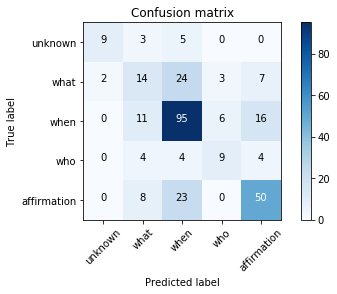

In [9]:
results = []
# Train Ridge Classifier
print('=' * 80)
print("Ridge Classifier" )
results.append(benchmark(RidgeClassifier(tol=1e-2, solver="sag")))

Liblinear model L1penalty
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.014s
test time:  0.001s
accuracy:   0.559

classification report:
             precision    recall  f1-score   support

    unknown       0.73      0.47      0.57        17
       what       0.39      0.24      0.30        50
       when       0.56      0.73      0.64       128
        who       0.56      0.48      0.51        21
affirmation       0.61      0.52      0.56        81

avg / total       0.55      0.56      0.55       297




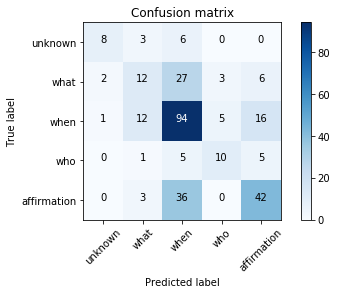

In [10]:
# Train Liblinear model
print('=' * 80)
print("Liblinear model L1penalty" )
results.append(benchmark(LinearSVC(C=1.0, loss='squared_hinge', penalty="l1", dual=False, tol=1e-3)))

Elastic-Net penalty
Training: 
SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.034s
test time:  0.000s
accuracy:   0.603

classification report:
             precision    recall  f1-score   support

    unknown       0.69      0.53      0.60        17
       what       0.44      0.24      0.31        50
       when       0.61      0.77      0.68       128
        who       0.53      0.38      0.44        21
affirmation       0.65      0.63      0.64        81

avg / total       0.59      0.60      0.59       297




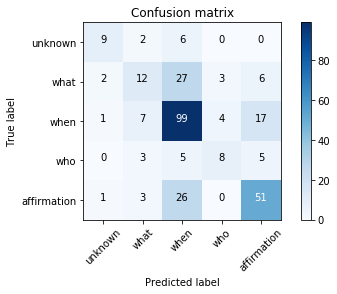

In [11]:
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.001, n_iter=50,penalty="elasticnet")))

# Plot Results

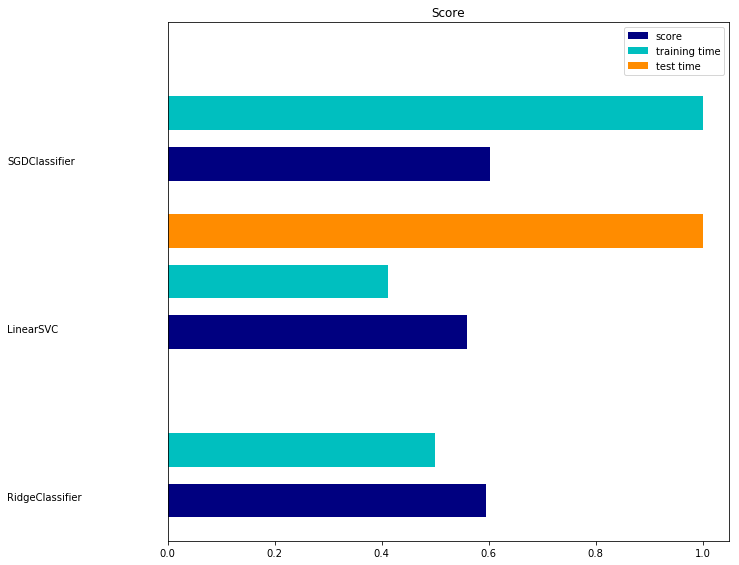

In [12]:
# make some plots

np.seterr(divide='ignore', invalid='ignore')
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()